In [1]:
import torch
from hydra import compose, initialize

import wandb
from src.eval.visualize import visualize_dvinp_both
from src.utils.load_dvinp import load_dvinp

In [2]:
try:
    import torch_directml
    device = torch_directml.device() 
except ImportError:
    device = torch.device("cpu") 

In [ ]:
# project = "cluster-noscore-fix2"
# run = "16-1-1-2-2-64-6-GELU-None-None-None-bca-free-dis-True-False" # "16-1-1-2-2-64-6-GELU-1-None-None-mean-free-dis-True-False"

# dir = f"../models/{project}/{run}"

# api = wandb.Api()

# for s in ["model.pth:v0", "optim.pth:v0", "cfg.yaml:v0"]:
#     artifact = api.artifact(f"{project}/{run}_{s}")
#     artifact.download(root=f"../models/{project}/{run}")

dir = f"../models/dvinp"

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


In [6]:
with initialize(version_base=None, config_path=dir):
    cfg = compose(config_name="cfg")

    model, trainer, test_loader = load_dvinp(
        cfg=cfg, 
        device=device, 
        dir=dir, 
        load_decoder_only=False, 
        train_decoder=True
    ) 


Generating tasks: 100%|██████████| 4096/4096 [00:00<00:00, 296936.74it/s]

loaded model from ../models/cluster-noscore-fix2/16-1-1-2-2-64-6-GELU-None-None-None-bca-free-dis-True-False/model.pth
loaded optim from ../models/cluster-noscore-fix2/16-1-1-2-2-64-6-GELU-None-None-None-bca-free-dis-True-False/optim.pth


In [7]:
trainer.wandb_logging = False
if trainer.wandb_logging:
    wandb.init(project="test", name="".join([f"({v})" for v in cfg.model.values()]))

In [ ]:
train = True

if train:
    # trainer.optimizer.param_groups[0]["lr"] = 0.1 * cfg.training.learning_rate
    # print(trainer.optimizer.param_groups[0]["lr"])

    num_epochs = 50
    losses = trainer.train(
        num_epochs=num_epochs,
        max_clip_norm=cfg.training.max_clip_norm,
        alpha=cfg.training.alpha,
        validate=False
    )

    # torch.save(dvinp.state_dict(), f"{dir}/dvinp.pth")

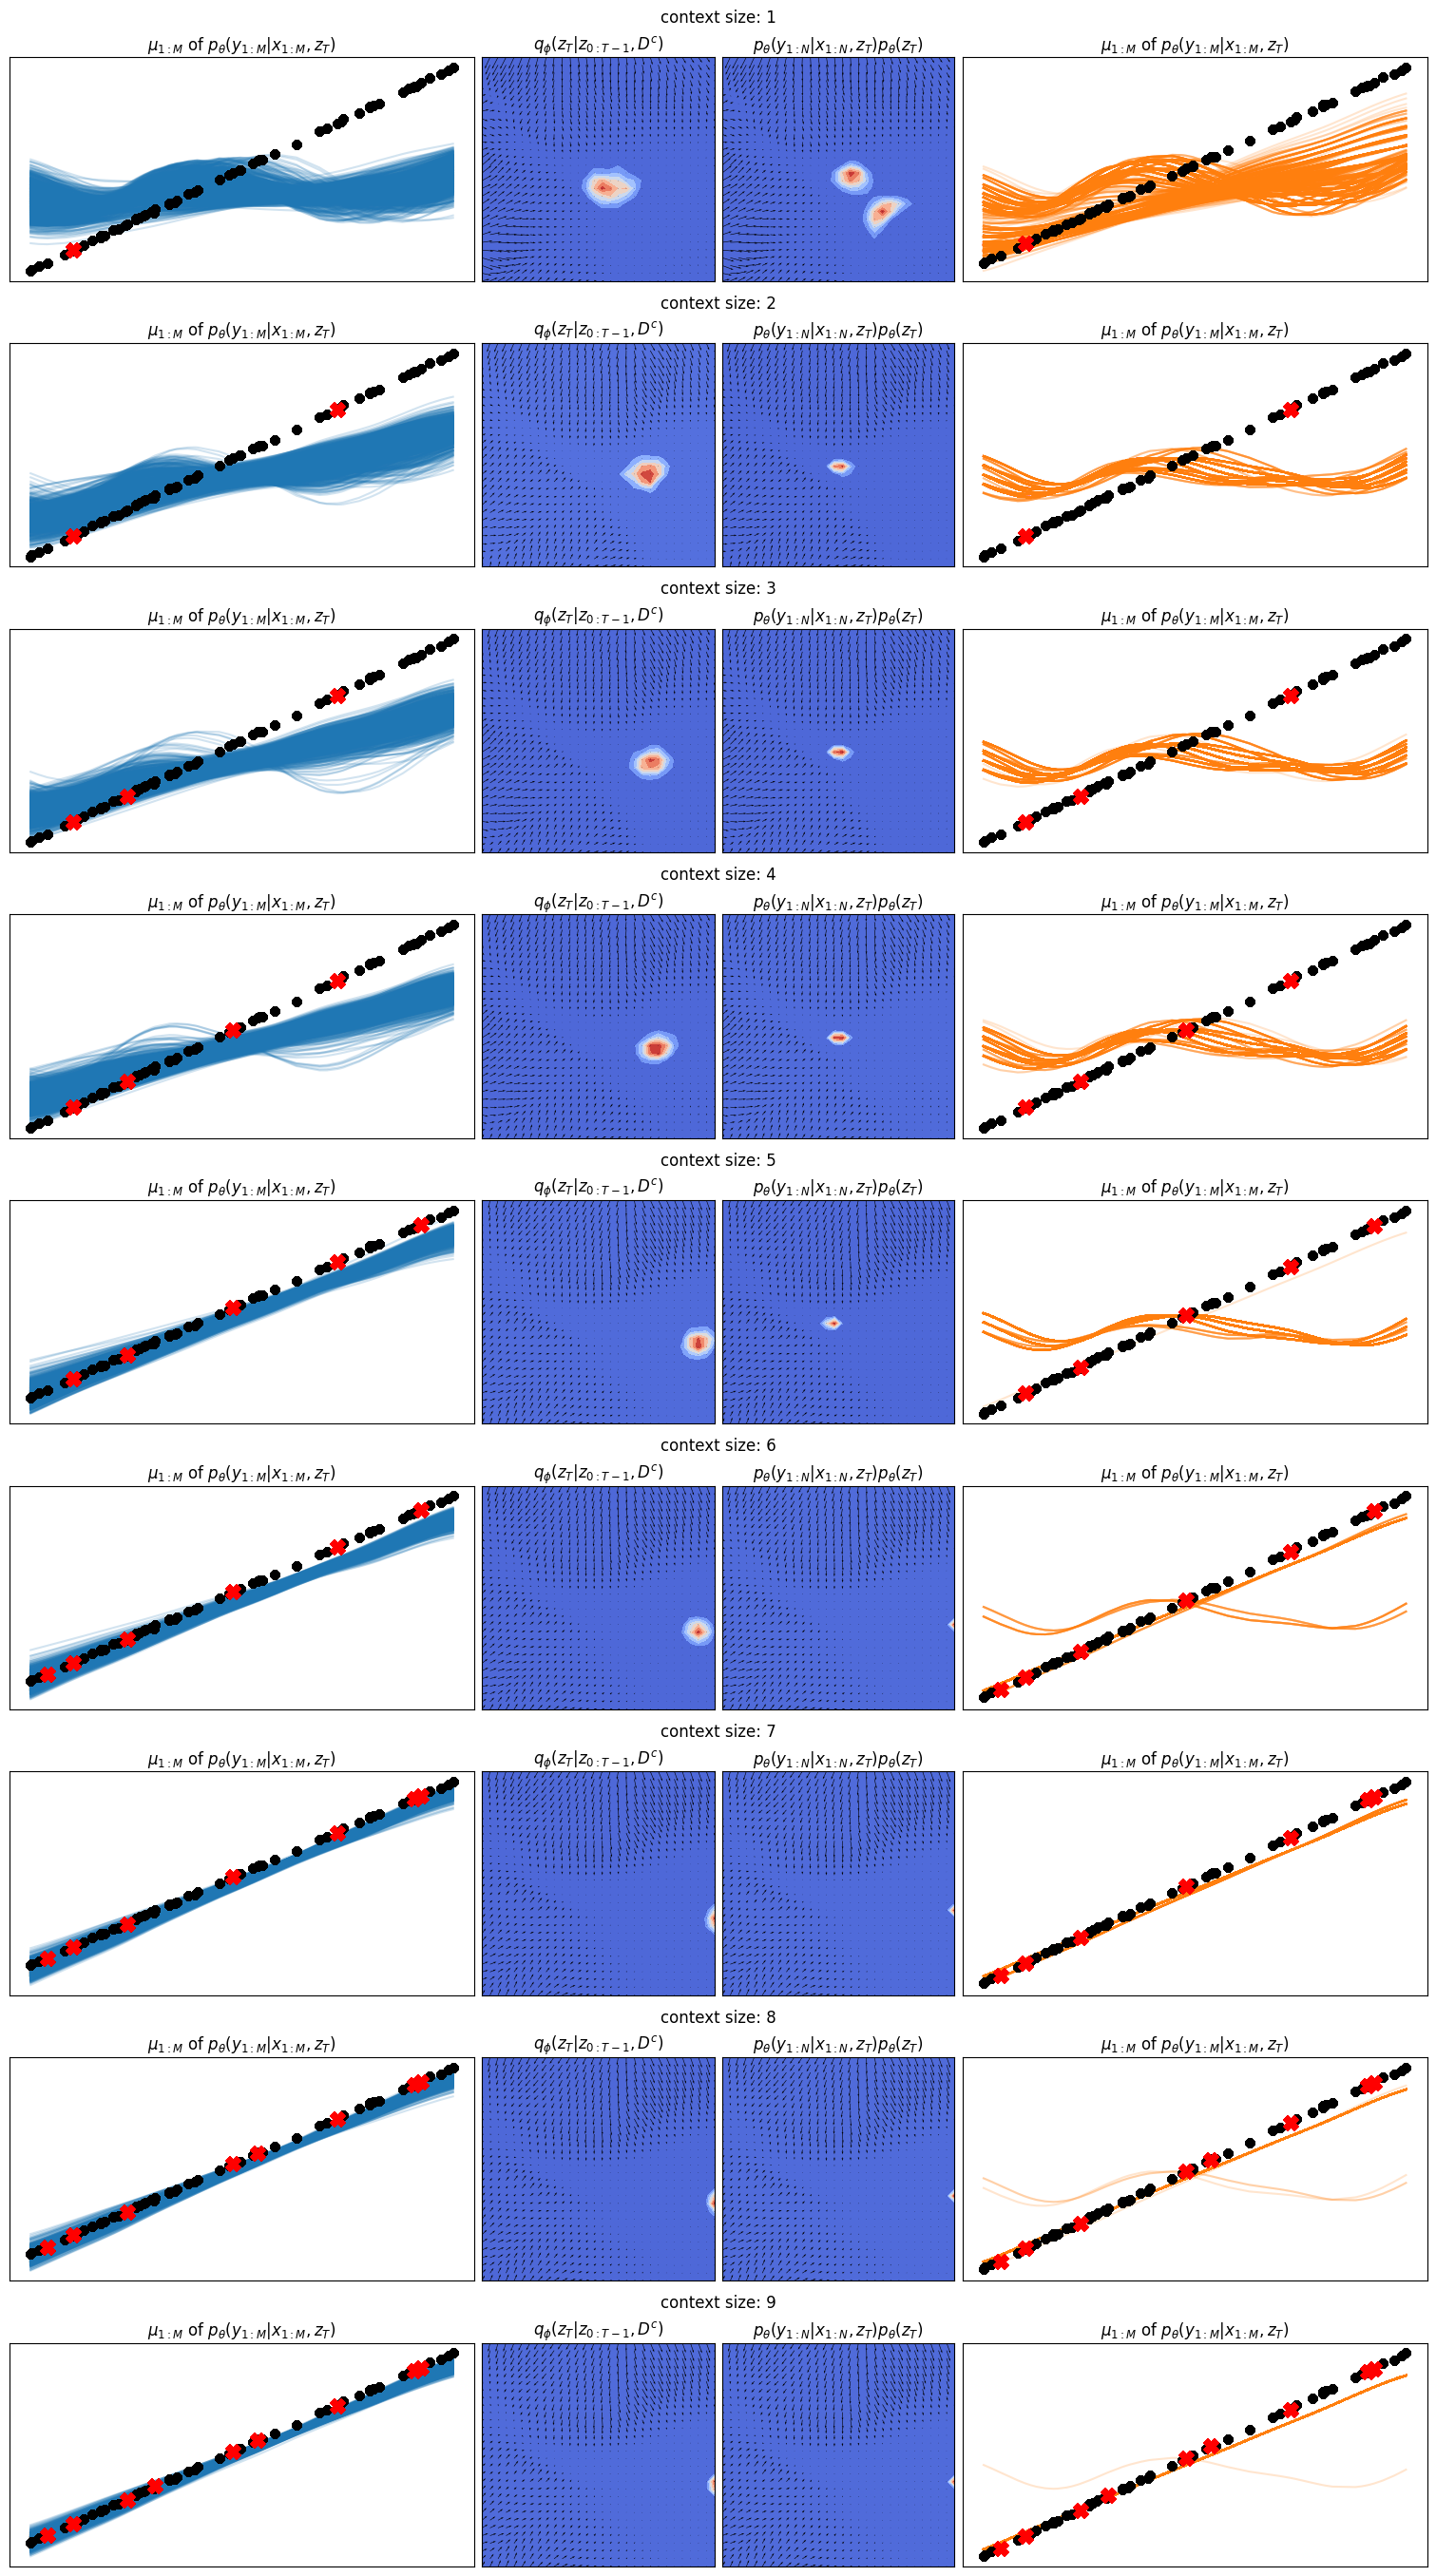

In [9]:
max_context_size = 9
num_samples = 900 # num_cells will be root

ranges = [(-5, 5), (-5, 5)]

targets, samples = visualize_dvinp_both(
    device=device,
    dvinp=model,
    dataloader=test_loader,
    num_samples=num_samples,
    max_context_size=max_context_size,
    ranges=ranges,
)